In [1]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
from dateutil import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn 
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.metrics import r2_score, mean_squared_error, classification_report,confusion_matrix, roc_curve, auc
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score,ShuffleSplit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression,LassoLars,Ridge
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.decomposition import PCA,TruncatedSVD
from scipy import stats

from IPython.display import display, HTML, Image
from subprocess import call
import gc

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100

# Introduction

This notebook showcases the work and investigation of trying to predict the total amount to be expected in July 2019. By July 2019, there are 4981 pets enrolled. Throughout this assessment I wanted to showcase my skills as a data scientist. I wanted to show my technical, analytical, qualitative, and writing work. 

For my technical skills, I wanted to show my computer science, data engineering, and work with various machine learning functions. The functions can be shown in the section "Functions". I created a few custom transformers and evaluation functions. The custom transformers are to showcase my ability to create and develop pipelines for machine learning models that incorporate categorical and numerical features. My evaluation function allows me to recreate model evaluations using different models. Finally, I do quite a bit of data pre-processing using pandas. Ideally, I would normally use SQL to pre-process most of my work as window functions are more intuitive. 

For my analytical and qualitative work, I showcase some initial exploratory analysis on the datasets I compiled and processed. I wanted to show some skills such as anomaly detection on the basic level. Especially, for a company in the insurance industry where there are anomalies/outliers when it comes to claims. I primarily wanted to showcase the exploration process and how visualizing data in various forms can lead to interesting results and show relationships that can be essential to modeling. 

Finally, I wanted to do two different approaches which I will call strategy 1 and 2. Strategy 1 will be a model that tries to predict pet id claim amounts based on input features. This approach uses a date - pet level data. I primarily wanted to show that I do have some experience with feature generation, and also show that feature generation is a process that is trying to optimize models. I realize this is most likely not the best approach because claim amounts on a pet level are related to better features that I did not have information. As a result, this strategy is a perfect example of showing that no matter what kind of model is created if the data itself doesn't have any success the resulting models will not. 

Strategy 2 creates a model based on month,year level and uses relationships of claim amounts vs. date as a function to create a linear regression. This strategy was devised based on the relationship from the EDA that time behaves with a linear relationship with total claim amounts. This model did overfit with a explained variance scores: Train Score = 0.97 and Test Score = 0.92. 

If I had extra time and data to do this type of project, I would want more features on the pet level. Features that can describe reason for visit, severity of claim, etc. This pet level data would be ideal to try to predict claim amounts on the pet level. Finally, its true that the question could have been solved quickly with the second strategy, but to do something quickly and simply doesn't showcase the skills that I possess as a data scientist. I wanted to show what I am capable of and that I can be useful to the company. I wanted to go above and beyond for this question and explore a little and understand the company itself.

# Functions

In [27]:
class ColumnSelector(TransformerMixin):
    def __init__(self,cols):
        self.cols = cols

    def transform(self, X, y=None):
        return X[self.cols]

    def fit(self, X, y=None):
        return self

    def get_feature_names(self):
        return X[self.cols].columns.tolist()

def build_dummies(dataframe,feats):
    df = pd.DataFrame()
    for feat in feats:
        df = pd.concat([df,pd.get_dummies(dataframe[feat],prefix=feat)],axis=1,sort=False)
    df = pd.concat([dataframe,df],axis=1,sort=False)
    df.drop(feats,axis=1,inplace=True)
    return df

def best_params(grid):
    best_index = grid.best_index_
    train_score = grid.cv_results_['mean_train_score'][best_index]
    estimator = grid.best_estimator_
    params = grid.best_params_
    #pca = grid.best_estimator_.steps[1][1]
    model = grid.best_estimator_.steps[2][1]
    test_score = grid.best_score_
    return estimator,model,params,test_score,train_score

def compute_error(est,X,y,cv):
    return -cross_val_score(est,X,y,cv=cv,scoring='neg_mean_absolute_error').mean()

def RegModelEval(DF,n=100,show=False,output='none'):
    df = DF.sample(n=n)
    y = df[output]
    y_pred = df.pred_out
    print('R^2 Test: {:.5f}'.format(r2_score(y,y_pred)))
    print('RMSE Test: {:.5f}'.format(mean_squared_error(y,y_pred,squared=False)))

    if show:
        plt.rcParams['figure.figsize'] = (8, 8)
        plt.scatter(y_pred[:n],(y_pred[:n]-y[:n]),c='lightgreen',marker='s',label='Test_data')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.legend(loc='upper left')
        #plt.hlines(y=0,xmin=-10,xmax=10,color='red',lw=2,linestyle='-')
        #plt.xlim([-1,1])
        plt.show()

# Data Processing

In [56]:
#normally I would use SQL to join and put together tables
#as window functions are much easier to do in SQL vs. pandas/python
claim_df = pd.read_csv('./claimdata.csv',parse_dates=['ClaimDate'])
pet_df = pd.read_csv('./petdata.csv',parse_dates=['EnrollDate','CancelDate'])
DF = claim_df.merge(pet_df,on='PetId')

#eliminate any large or small outliers
DF.sort_values(by=['PetId','ClaimDate'],inplace=True)
pet_df.sort_values('EnrollDate',inplace=True)

In [57]:
#for each enroll date, count how many petids are enrolled at that current date
#count each cancelled petid and subtract that from the total enrolled by that date
stats = {}
for i,row in pet_df.iterrows():
    date = row.EnrollDate
    enroll_ct = pet_df.loc[pet_df.EnrollDate <= date].shape[0]
    cancelled_ct = pet_df.loc[pet_df.CancelDate <= date].shape[0]
    current_enrolled = enroll_ct - cancelled_ct
    if date not in stats:
        stats[date] = current_enrolled
enroll_df = pd.DataFrame(stats.items(),columns=['Date','Enrolled'])
enroll_df['Month'] = enroll_df.apply(lambda row: row.Date.month_name(),axis=1)
enroll_df['Year'] = enroll_df.apply(lambda row: row.Date.year,axis=1)
enroll_df = enroll_df.groupby(['Year','Month']).max().sort_values('Date').reset_index()

## Dataset for Strategy 1

In [58]:
#Feature Generation
ages = {'0-7 weeks old': 0,
        '8 weeks to 12 months old': .5, 
        '1 year old': 1,
        '2 years old': 2,
        '3 years old': 3,
        '4 years old': 4,
        '5 years old': 5,
        '6 years old': 6,
        '7 years old': 7,
        '8 years old': 8,
        '9 years old': 9,
        '10 years old': 10,
        '11 years old': 11,
        '12 years old': 12,
        '13 years old': 13}
DF['Quarter'] = DF.apply(lambda row: row.ClaimDate.quarter,axis=1)
DF['ClaimMonth'] = DF.apply(lambda row: row.ClaimDate.month_name(),axis=1)
DF['ClaimMonthNum'] = DF.apply(lambda row: row.ClaimDate.month,axis=1)
DF['ClaimYear']  = DF.apply(lambda row: row.ClaimDate.year,axis=1)
DF['EnrollMonth'] = DF.apply(lambda row: row.EnrollDate.month_name(),axis=1)
DF['EnrollYear'] = DF.apply(lambda row: row.EnrollDate.year,axis=1)
DF['EstEnrollAge'] = DF.apply(lambda row: ages[row.AgeAtEnroll],axis=1)
DF['DaysFromEnroll'] = DF.apply(lambda row:(row.ClaimDate-row.EnrollDate).days , axis=1)
DF['YearsFromEnroll'] = round(DF.DaysFromEnroll/365.0).astype(int)
DF['MonthsFromEnroll'] = DF.apply(lambda row:int(round((row.ClaimDate-row.EnrollDate).days/365*12)) , axis=1)
DF['EstCurrentAge'] = DF.EstEnrollAge+DF.YearsFromEnroll
DF['Cancelled'] = DF.apply(lambda row: 'No' if row.CancelDate is pd.NaT else 'Yes',axis=1)
DF['PreviousClaims'] = (DF.groupby('PetId').ClaimDate.rank(method='min')-1).astype(int)
DF['PreviousClaimsYear'] = (DF.groupby(['PetId','ClaimYear']).ClaimDate.rank(method='min')-1).astype(int)


#Get Avg visits per year for petId 
#Get Avg Claim Amt per visit per year
visit_df = DF.groupby(['PetId','ClaimYear'])[['ClaimId']].count().groupby('PetId').mean()
claim_amt_avg = DF.groupby(['PetId','ClaimYear'])[['ClaimAmount']].sum().groupby('PetId').mean()
df1 = visit_df.merge(claim_amt_avg,on='PetId')
df1.rename(columns={'ClaimId': 'AvgYearlyVisits','ClaimAmount':'AvgYearlyClaimAmt'},inplace=True)

#get average claim amount for breed & species
breed_df = DF.groupby(['Breed','Species'])[['ClaimAmount']].mean()
breed_df.rename(columns={'ClaimAmount': 'AvgYearlyBreedSpeciesClaimAmt'},inplace=True)
DF = DF.merge(breed_df,on=['Breed','Species'])

#Create Final table
DF = DF.merge(df1,on='PetId')
DF = DF.loc[DF.ClaimAmount.between(DF.ClaimAmount.quantile(.25),DF.ClaimAmount.quantile(.75))]

#clear/free memory
del [visit_df,claim_amt_avg,df1,breed_df,claim_df]
gc.collect()

"""
Unused Code/Features
This code below is unused. I originally tried to incorporate quarterly features
But found this to not really do anything. 
"""
#Create Aggregate of Quarterly ClaimAmt Totals
#sum amount is based on quarter, year, breed, ageatenroll, and species
#quarter_claimamt = DF.groupby(['Quarter','ClaimYear','Breed','Species','AgeAtEnroll']).ClaimAmount.sum().reset_index()
#quarter_claimamt.rename(columns={'ClaimAmount':'QuarterClaimAmtTotal'},inplace=True)
#DF = DF.merge(quarter_claimamt,on=['Quarter','ClaimYear','Breed','Species','AgeAtEnroll'])  

#Create Quarterly Stats Features
#DF['QuarterAmt%'] = DF.PetQAmtTotal/DF.QuarterClaimAmtTotal
#DF['PetQAmtTotal'] = DF.groupby(['PetId','Quarter','ClaimYear']).ClaimAmount.apply(lambda row: row.shift().cumsum())
#DF.PetQAmtTotal.fillna(0,inplace=True)

'\nUnused Code/Features\nThis code below is unused. I originally tried to incorporate quarterly features\nBut found this to not really do anything. \n'

## Dataset for Strategy 2

In [50]:
#Feature Generation for strategy 2
DF['ClaimMonth'] = DF.apply(lambda row: row.ClaimDate.month_name(),axis=1)
DF['ClaimMonthNum'] = DF.apply(lambda row: row.ClaimDate.month,axis=1)
DF['ClaimYear']  = DF.apply(lambda row: row.ClaimDate.year,axis=1)

#Get ClaimMonth,ClaimYear statistics
#Get Avg visits for each month,year
#Get Avg Claim Amt for each month,year
#Get number of active PetIds that are enrolled
visit_df = DF.groupby(['ClaimMonth','ClaimYear'])[['ClaimId']].count().reset_index()
claim_amt_total = DF.groupby(['ClaimMonth','ClaimYear'])[['ClaimAmount']].sum().reset_index()
df1 = visit_df.merge(claim_amt_total,on=['ClaimMonth','ClaimYear'])
df1.rename(columns={'ClaimId': 'TotalVisits','ClaimAmount':'ClaimAmtTotal'},inplace=True)

#Create Final table
DF = df1.merge(enroll_df,left_on=['ClaimMonth','ClaimYear'],right_on=['Month','Year'])

#clear/free memory
del [visit_df,claim_amt_total,df1,claim_df]
gc.collect()


0

In [51]:
DF.sort_values('Date',inplace=True)
DF

,ClaimMonth,ClaimYear,TotalVisits,ClaimAmtTotal,Year,Month,Date,Enrolled
38,January,2010,7,708.98,2010,January,2010-01-31,66
28,February,2010,7,785.02,2010,February,2010-02-28,92
67,March,2010,1,75.90,2010,March,2010-03-31,109
0,April,2010,7,904.91,2010,April,2010-04-30,146
77,May,2010,10,1219.05,2010,May,2010-05-31,181
57,June,2010,17,3969.60,2010,June,2010-06-29,229
48,July,2010,23,11179.47,2010,July,2010-07-31,280
10,August,2010,24,12113.15,2010,August,2010-08-31,313
105,September,2010,23,10138.17,2010,September,2010-09-30,349
96,October,2010,22,3628.63,2010,October,2010-10-31,411


# Exploratory Analysis

Notes 
- I have insured the data makes sense. Claim Dates > Enroll Dates and Claim Dates < Cancelled Dates
- Every PetId has in dataset has enroll date. No PetId appears twice in dataset, as a result if a pet has a canceldate it doesnt have a re-enroll date. 


## Anomaly Detection & Feature investigation

- By just plotting the ClaimAmount you can see that outliers exist
- These outliers seem to be the "premium" claims

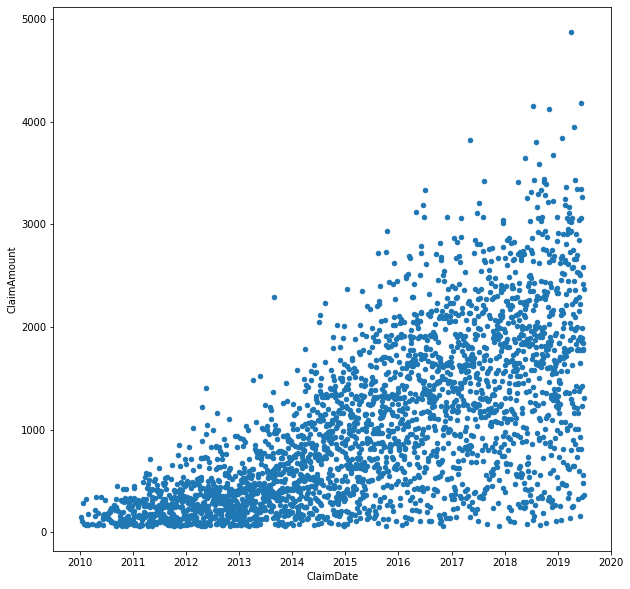

In [191]:
df1 = DF.groupby('ClaimDate')[['ClaimAmount']].sum().reset_index()
df1.plot(x='ClaimDate',y='ClaimAmount',kind='scatter',figsize=(10,10))

Now we take out some outliers by looking at data within quantiles

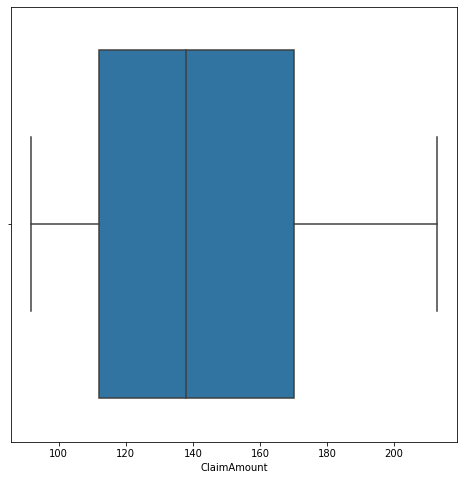

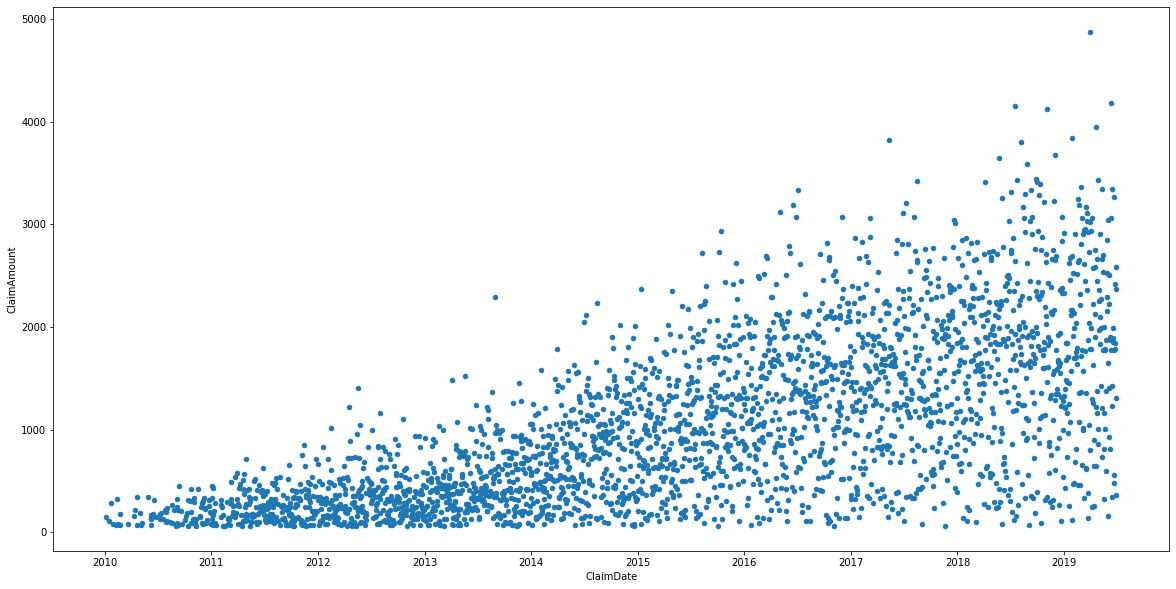

In [192]:
#eliminate any large or small outliers
#use the data between the 25%-75% quantiles
#This will help with the model prediction to not wildy predict values

df = DF.loc[DF.ClaimAmount.between(DF.ClaimAmount.quantile(.25),DF.ClaimAmount.quantile(.75))]
sns.boxplot(x=df['ClaimAmount'])
df1 = df1.groupby('ClaimDate')[['ClaimAmount']].sum().reset_index()
df1.plot(x='ClaimDate',y='ClaimAmount',kind='scatter',figsize=(20,10))

From observations, you can see that no real linear regression exists. The claim amounts have been growing as the year increases.
There doesn't seem to be any periodic behaviors happening yearly. You can notice that since 2010 the claim amounts have been increasing. 

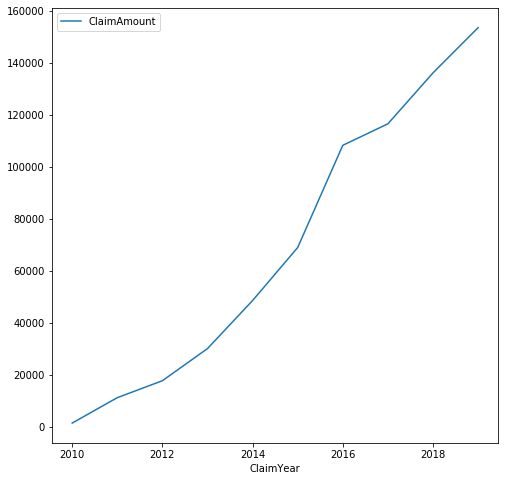

In [193]:
#Let us examine what the claim amounts were from 2010-2019 
#Since 2019 only has data from Jan-June
temp = df.loc[df.ClaimMonthNum.isin(np.arange(1,7))]
temp.groupby('ClaimYear')[['ClaimAmount']].sum().plot()

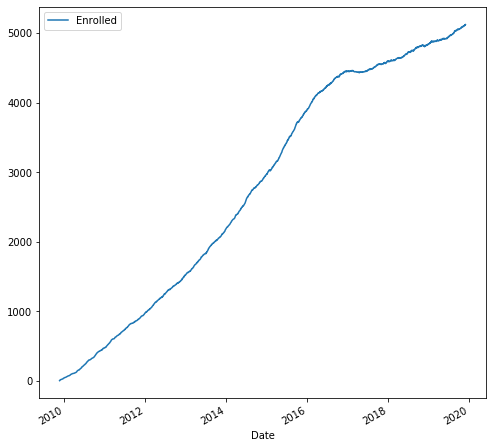

In [196]:
enroll_df.plot(x='Date',y='Enrolled')

What is interesting is that the claim amount per year, when you eliminate outliers does increase at a very linear rate. So we can at least use a sanity check to expect a larger amount in claims in Jan-july 2019 than jan-july 2018. 

Also, Note that that with increase in ClaimAmount porportional to the number of petids enrolled. 

Let us exam this further, by observing Claim Totals by Species, Breed

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

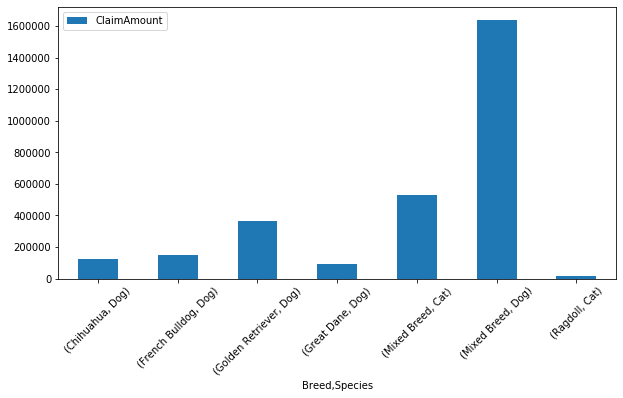

In [335]:
df1 = df.groupby(['Breed','Species'])[['ClaimAmount']].sum()#reset_index()
df1.plot(kind='bar',figsize=(10,5))
plt.xticks(rotation=45)

This clearly shows that within the data mixed breed dogs make up the majority of the claim amounts. This can also mean that most of the data consists of mixed breed dogs. 

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

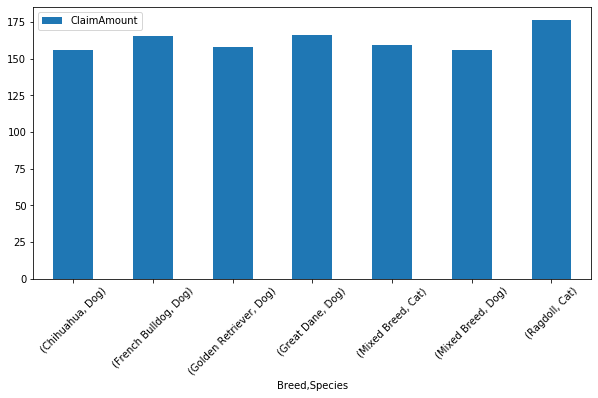

In [362]:
#here we have average claim amount throughout history for the various breeds & species
df1 = df.groupby(['Breed','Species'])[['ClaimAmount']].mean()
df1.plot(kind='bar',figsize=(10,5))
plt.xticks(rotation=45)

Yearly, it can be observed that breed,species should be getting fairly the same claim amounts on average. 

Let's look at the claim amounts as a function of month,year. 

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text xticklabel objects>)

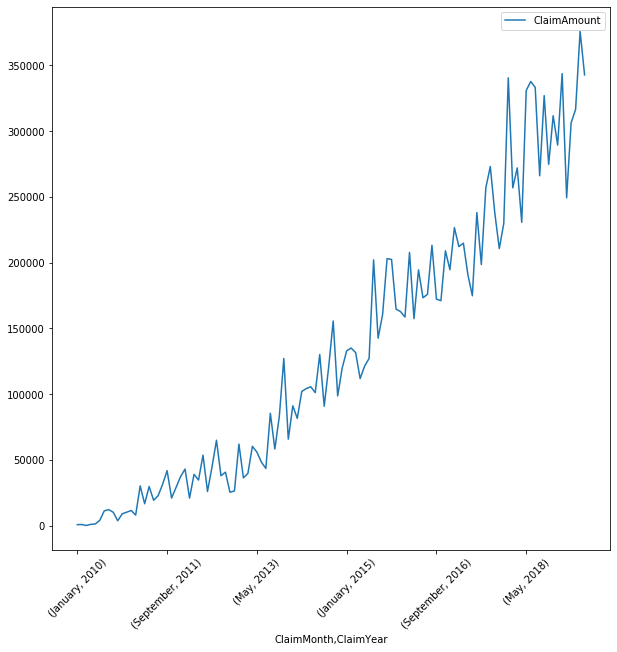

In [186]:
df1 = DF.loc[DF.ClaimYear >= 2010].groupby(['ClaimMonthNum','ClaimMonth','ClaimYear'])[['ClaimAmount']].sum().reset_index()
df1 = df1.sort_values(by=['ClaimYear','ClaimMonthNum']).set_index(['ClaimMonth','ClaimYear'])
df1[['ClaimAmount']].plot(figsize=(10,10))
plt.xticks(rotation=45)

When you look at claims amounts as a function of the time in month,year you do tend to see a increase in claims4. How that fairs on a per pet id level is different. 

## Thoughts

I want to approach this problem with 2 different strategies based on my exploratory analysis. 

1. I want to try to model at a petid-claim level and see how good I can get individual pet id predictions. Then I can predict each petId that hasn't cancelled by July 2019 and get a predicted lower,upper, and mean value for 50,60,80,90% confidence level values. I can then sum these predicted values to get what we'd expected sum with prediction level and get a value per petId for claim amounts. I can use a sanity check of Jan-July 2018 to see if the expected value is above that as noticed in exploratory analysis that Jan-July 2019 should be greater. 

2. I want to reduce the data to a claim month,year level and try to predict the total amount of claims for July 2019. 


# Features Strategy 1

In [5]:
"""
Assume all pets are treated equally 
    -> petid won't be used in fts
    
Fts 1.0
'ClaimMonth' = Claim month
'ClaimYear' = Claim Year
'EnrollMonth' = Enroll month
'EnrollYear'= Enroll Year
'PreviousClaims' = # of previous claims prior to the current claim for pet id
'EstCurrentAge' = Estimated Current Age 
'EstEnrollAge' = estimated enrollment age
'MonthsFromEnroll' = # of months from enrollment

Fts 2.0 
Added 
'Species' = Species of animal
'Breed' = Breed of animal

Fts 3.0
Add/Generate
Quarter = Quarter for that year
PreviousClaimsYear = # of claims prior to current claim for that year
PetQAmtTotal = Total Claim Amount for that PetId for that quarter and year
QuarterAmt% = Total Amount % for that PetId prior to the current claim
= PetId,Quarter,Year Claim Amt/Total Amount Breed,Species,AgeAtEnroll,Quarter,Year

Fts 4.0
Removed 
PetQAmtTotal
QuarterAmt%

Added
AvgYearlyVisits = Avg Yearly Visits for PetId
AvgYearlyClaimAmt = Avg Yearly Claim Amount for PetId
***only look at data from 2018-2019

Fts 5.0
Added 
AvgYearlyBreedSpeciesClaimAmt = Avg Yearly Claim Amount for Breed&Species
***Look at 2010-2019 data
"""
print('')

In [59]:
#Select DataFrame Population
#DF = DF.loc[DF.ClaimYear>=2018]

#determining categorical and numerical features
categorical = ['ClaimMonth',
               'ClaimYear',
               'EnrollMonth',
               'EnrollYear',
               'Species',
               'Breed'
               #'Quarter'
              ]
numerical = ['PreviousClaims',
             'EstCurrentAge',
             'EstEnrollAge',
             'MonthsFromEnroll',
             'PreviousClaimsYear',
             'AvgYearlyVisits',
             'AvgYearlyClaimAmt',
             'AvgYearlyBreedSpeciesClaimAmt'
             #'PetQAmtTotal'
             #'QuarterAmt%'
             #'YearsFromEnroll'
             #'DaysFromEnroll'
            ]
features = categorical + numerical
X = DF[features]
y = DF['ClaimAmount']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

# Features Strategy 2

In [10]:
"""    
Fts 1.0
ClaimMonth = Month of Claims
ClaimYear = Year of Claims
Enrolled = # of pets enrolled at the current time in that month, year
"""
print('')

In [9]:
#determining categorical and numerical features
categorical = ['ClaimMonth',
               'ClaimYear'
              ]
numerical = ['Enrolled']
features = categorical + numerical
X = DF[features]
y = DF['ClaimAmtTotal']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

# PC Analysis Using Dataset for Strategy 1

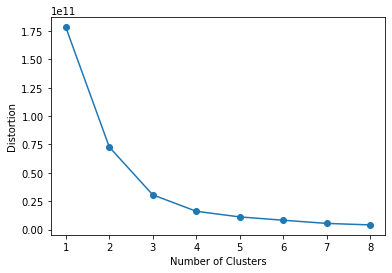

In [10]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

x = build_dummies(DF[features],categorical)
#determine optimal clusters k
distortions = []
for i in range(1,9):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(x)
    distortions.append(km.inertia_)
plt.plot(range(1,9),distortions,marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

In [11]:
pca = PCA(n_components=2)
pca.fit(x)
pca_PCs = pca.transform(x)
print(pca.explained_variance_ratio_)

RR = x.cov()
eig_val, eig_vec = np.linalg.eig(RR)
pc_label = ['PC%d' % (i+1)for i in range(len(x.columns))]
dfEig = pd.DataFrame(eig_vec,index=x.columns,columns=pc_label)
print('EigenVectors\n')
dfEig.sort_values(['PC1','PC2'],ascending=[0,0])[['PC1','PC2']]

[9.99738396e-01 1.11804297e-04]
EigenVectors



,PC1,PC2
Species_Cat,1.147913e-05,-0.000827
EnrollYear_2012,9.192899e-06,-0.000667
EnrollYear_2016,5.906912e-06,0.001353
Breed_Golden Retriever,5.278787e-06,-0.001179
EnrollMonth_September,4.162552e-06,-0.000005
ClaimYear_2013,4.160226e-06,0.000898
EnrollMonth_July,3.917786e-06,0.000191
ClaimYear_2012,3.023961e-06,0.000683
EnrollYear_2011,2.983439e-06,-0.001224
EnrollMonth_December,2.889890e-06,0.000291


I did a PCA on the features. You can see that PC1 does explain 99.7% of the variance of the data, where AvgYearlyClaimAmt seems to be the value that strongly accounts for the variance. 

# PCA for Strategy 2

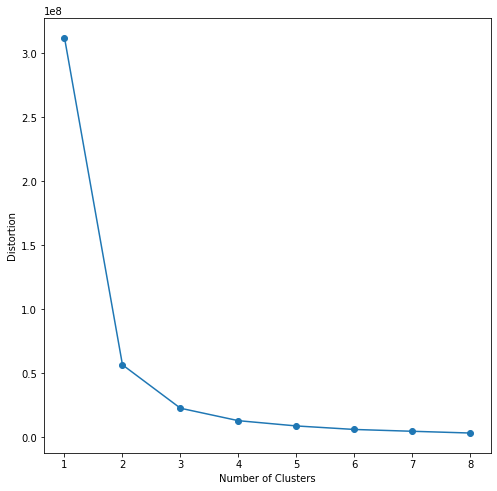

[9.99368645e-01 6.30755381e-04]
EigenVectors



,PC1,PC2
ClaimYear_2010,9.684152e-05,0.002458
ClaimYear_2011,7.763907e-05,0.000947
ClaimYear_2012,5.764387e-05,-0.000493
ClaimYear_2013,3.442996e-05,-0.001916
ClaimYear_2014,5.343723e-06,-0.001743
ClaimMonth_January,3.789170e-06,0.000037
ClaimMonth_February,2.709272e-06,-0.001227
ClaimMonth_July,2.577186e-06,0.000221
ClaimMonth_March,1.216742e-06,0.000802
ClaimMonth_August,1.187084e-06,0.000570


In [229]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

x = build_dummies(DF[features],categorical)
#determine optimal clusters k
distortions = []
for i in range(1,9):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(x)
    distortions.append(km.inertia_)
plt.plot(range(1,9),distortions,marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

pca = PCA(n_components=2)
pca.fit(x)
pca_PCs = pca.transform(x)
print(pca.explained_variance_ratio_)

RR = x.cov()
eig_val, eig_vec = np.linalg.eig(RR)
pc_label = ['PC%d' % (i+1)for i in range(len(x.columns))]
dfEig = pd.DataFrame(eig_vec,index=x.columns,columns=pc_label)
print('EigenVectors\n')
dfEig.sort_values(['PC1','PC2'],ascending=[0,0])[['PC1','PC2']]

Should not be surprised that the # of visits & # of enrolled at time explain majority of variance in the data

# Modeling Strategy 1

Recap of the modeling strategy 1
1. I want to try to model at a petid-claim level and see how good I can get individual pet id predictions. Then I can predict each petId that hasn't cancelled by July 2019 and get a predicted lower,upper, and mean value for 50% confidence level values. I can then sum these predicted values to get what we'd expected sum with prediction level and get a value per petId for claim amounts. I can use a sanity check of Jan-July 2018 to see if the expected value is above that as noticed in exploratory analysis that Jan-July 2019 should be greater. 

I will demonstrate few models: Linear, Ridge, and Gradient Boosted Regressions. I normally run data through Linear Model first as it is the quickest. If the results seem to be improving I will run them through the other models. 

For each model, I will create a param_grid of params to run through my GridSearchCV. Also, I created a pipeline that will combine numerical and categorical values (using one hot encoding) together. The pipeline combines the features together, then runs them thru a standardization process, and then trains the data on the model. Finally, I will record each train & test score for each of the models to document my success

In [7]:
#cross validation
#test/validation set being 25% of the 80% of training size being 20% of the original set of data. 
cv = ShuffleSplit(n_splits=100,test_size=.25,random_state=42)

## Linear Regression

Linear Regression is the most basic of regression techniques. I am using it due to the speed it takes to train a model. This allows me to see scores before applying them to the Gradient Boosted Model, which tends to do better but takes more time to train.

In [10]:
param_grid = [{'mdl__normalize': [True,False],
               'mdl__fit_intercept': [True,False]}
             ]

pipe = Pipeline([
        ('features',FeatureUnion([
            ('numeric_feats',ColumnSelector(cols=numerical)),
            ('categorical_feats',Pipeline([
                ('categories',ColumnSelector(cols=categorical)),
                ('encoder',OneHotEncoder(handle_unknown='ignore',sparse=False)),
            ]))
        ])),
        ('ft_scale',StandardScaler(with_mean=False)),
        ('mdl',LinearRegression())
])

In [11]:
gs_dt = GridSearchCV(pipe,
                    param_grid,
                    scoring='neg_mean_absolute_error',
                    return_train_score=True,
                    cv=cv,n_jobs=5,verbose=3,error_score='raise')
gs_dt.fit(X_train,y_train)

Fitting 100 folds for each of 4 candidates, totalling 400 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    6.2s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:   13.9s
[Parallel(n_jobs=5)]: Done 400 out of 400 | elapsed:   19.6s finished


GridSearchCV(cv=ShuffleSplit(n_splits=100, random_state=42, test_size=0.25, train_size=None),
             error_score='raise',
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('numeric_feats',
                                                                        <__main__.ColumnSelector object at 0x7fab64f18c10>),
                                                                       ('categorical_feats',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('categories',
                                                                                         <__main__.ColumnSe...
                                        StandardScaler(copy=True,
                            

In [13]:
"""
First Model: Linear Regression with MSE -435.9
After getting rid of outliers and only keeping ClaimAmounts within .15 and.85 quantiles
2nd Mode: Linear Regression with Train Score: -84.34484502328665, Test Score: -84.55708379303553 
3rd Linear Regression: Train Score: -84.22301290538599, Test Score: -84.47510896566668
-added in species and breed as I forgot those in firstpass of fts
4th Linear: Train Score: -107.43126314041506, Test Score: -107.93260471233896
-fts 3.0 made the model more complex causing it to do more poorly
5th Linear: Train Score: -69.05771131405827, Test Score: -69.8702634668454
-fts 4.0 and smaller population
6th Linear: Train Score: -65.35259371380612, Test Score: -65.6359562450615
-fts 5.0
"""

estimator,model,params,test_score,train_score = best_params(gs_dt)
print('Train Score: {}, Test Score: {}'.format(train_score,test_score))

Train Score: -65.35259371380612, Test Score: -65.6359562450615


## Ridge  Regressions

I create and develop a Ridge Regression Model. First, I plot alpha values with Mean Squared Error to try to minimize MSE. This will give me a range of alpha values that I can use for my GridSearch

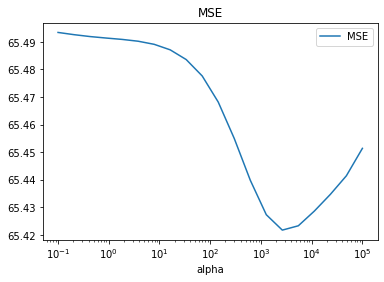

In [15]:
np.random.seed(42)

#Ridge Regression Alpha value using cross_val_score
alphas = np.logspace(-1, 5, 20)
x = build_dummies(DF[features],categorical)

ridge_models = pd.DataFrame(
    [(alpha,
      "Ridge Regression with alpha = %f" % alpha, 
      compute_error(Ridge(alpha=alpha), x, y,cv)) for alpha in alphas],
    columns=['alpha', 'Model', 'MSE'])
ridge_models.plot(x='alpha', y='MSE', logx=True, title='MSE')

In [16]:
param_grid = [{'mdl__normalize': [True,False],
               'mdl__fit_intercept': [True,False],
               'mdl__alpha': np.logspace(2, 4, 20)
              }
        ]

pipe = Pipeline([
        ('features',FeatureUnion([
            ('numeric_feats',ColumnSelector(cols=numerical)),
            ('categorical_feats',Pipeline([
                ('categories',ColumnSelector(cols=categorical)),
                ('encoder',OneHotEncoder(handle_unknown='ignore',sparse=False)),
            ]))
        ])),
        ('ft_scale',StandardScaler(with_mean=False)),
        ('mdl',Ridge())
])

In [17]:
gs_dt = GridSearchCV(pipe,
                    param_grid,
                    scoring='neg_mean_absolute_error',
                    return_train_score=True,
                    cv=cv,n_jobs=5,verbose=3,error_score='raise')
gs_dt.fit(X_train,y_train)

Fitting 100 folds for each of 80 candidates, totalling 8000 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:   11.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:   20.6s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:   32.2s
[Parallel(n_jobs=5)]: Done 1142 tasks      | elapsed:   46.5s
[Parallel(n_jobs=5)]: Done 1558 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 2038 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 2582 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 3862 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 4598 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 5398 tasks      | elapsed:  3.8min
[Parallel(n_jobs=5)]: Done 6262 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 7190 tasks      | elapsed:  5.0min


GridSearchCV(cv=ShuffleSplit(n_splits=100, random_state=42, test_size=0.25, train_size=None),
             error_score='raise',
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('numeric_feats',
                                                                        <__main__.ColumnSelector object at 0x7f2451044250>),
                                                                       ('categorical_feats',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('categories',
                                                                                         <__main__.ColumnSe...
         263.66508987,   335.98182863,   428.13323987,   545.55947812,
         695.19279618, 

In [21]:
"""
Ridge Regression Model (1stModel): Train Score: -83.13196512256529, Test Score: -83.24339901402183
Ridge Regression Model (2nd Model) : Train Score: -82.90493096123082, Test Score: -83.01895029736687
-Re-did some of the features, didn't calculate previous claims correctly before
-Still kept quantiles .2 and .8 to eliminate outliers
Ridge Regression Model (3rd Model): Train Score: -83.24680274524906, Test Score: -83.36952057997398
-fts 2.0
Ridge Model (4th): Train Score: -68.94175417661921, Test Score: -69.30057653242189
-fts 4.0
Ridge Model (5th): Train Score: -65.36187022355301, Test Score: -65.62592003207712
-fts 5.0
"""
estimator,model,params,test_score,train_score = best_params(gs_dt)
print('Train Score: {}, Test Score: {}'.format(train_score,test_score))

Train Score: -65.36187022355301, Test Score: -65.62592003207712


## Version 3: XGBoost

This is my gradient boosted regression model using XGBoost. Pros of XGBoost allows for better execution speeds and model performance. Each subsequent model created will be added to it previous weak learners. Each subsequent model will try  to add correct errors made previously by other models before it. 

In [8]:
from xgboost import XGBRegressor

In [11]:
param_grid = [{'mdl__max_depth': [2,4,6],
               'mdl__learning_rate': np.arange(.1,.22,.02),
               'mdl__n_estimators': [20,50,100]
              }
        ]

pipe = Pipeline([
        ('features',FeatureUnion([
            ('numeric_feats',ColumnSelector(cols=numerical)),
            ('categorical_feats',Pipeline([
                ('categories',ColumnSelector(cols=categorical)),
                ('encoder',OneHotEncoder(handle_unknown='ignore',sparse=False)),
            ]))
        ])),
        ('ft_scale',StandardScaler(with_mean=True)),
        ('mdl',XGBRegressor(min_child_weight=1,
                            random_state=42,
                            verbose=1,
                            objective='reg:squarederror'))
])

In [12]:
gs_dt = GridSearchCV(pipe,
                    param_grid,
                    scoring='neg_mean_absolute_error',
                    return_train_score=True,
                    cv=cv,n_jobs=2,verbose=3,error_score='raise')
gs_dt.fit(X_train,y_train)

Fitting 100 folds for each of 54 candidates, totalling 5400 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   20.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done 1148 tasks      | elapsed:  7.7min
[Parallel(n_jobs=2)]: Done 1564 tasks      | elapsed: 10.6min
[Parallel(n_jobs=2)]: Done 2044 tasks      | elapsed: 14.5min
[Parallel(n_jobs=2)]: Done 2588 tasks      | elapsed: 18.4min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed: 22.6min
[Parallel(n_jobs=2)]: Done 3868 tasks      | elapsed: 28.1min
[Parallel(n_jobs=2)]: Done 4604 tasks      | elapsed: 33.9min
[Parallel(n_jobs=2)]: Done 5400 out of 5400 | elapsed: 40.4min finished


GridSearchCV(cv=ShuffleSplit(n_splits=100, random_state=42, test_size=0.25, train_size=None),
             error_score='raise',
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('numeric_feats',
                                                                        <__main__.ColumnSelector object at 0x7f8e9b1c0810>),
                                                                       ('categorical_feats',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('categories',
                                                                                         <__main__.ColumnSe...
                                                     scale_pos_weight=1,
                     

In [15]:
"""
XGBoost Regression Model (1st Model): Train Score: -78.23114354701887, Test Score: -80.70723277660375
XGBoost Regreesion (2nd):Train Score: -78.04236184800338, Test Score: -80.57903280015569
-using fts 2.0
XGBoost reg (3rd): Train Score: -57.78508463847379, Test Score: -62.96848157586415
-fts 4.0
XGBoost Regression (4th): Train Score: -58.64477859175682, Test Score: -61.16395602796486
-fts 5.0
"""
estimator,model,params,test_score,train_score = best_params(gs_dt)
print('Train Score: {}, Test Score: {}'.format(train_score,test_score))

import pickle
pickle.dump(gs_dt,open('./xgboostregessor.pkl','wb'))

Train Score: -58.64477859175682, Test Score: -61.16395602796486


## Model Evaluation

In [60]:
import pickle
gs_dt = pickle.load(open('./xgboostregessor.pkl','rb'))

The Model Evaluation will use the best scored model, which is the Gradient Boosted Regressor

R^2 Test: 0.06315
RMSE Test: 74.97347


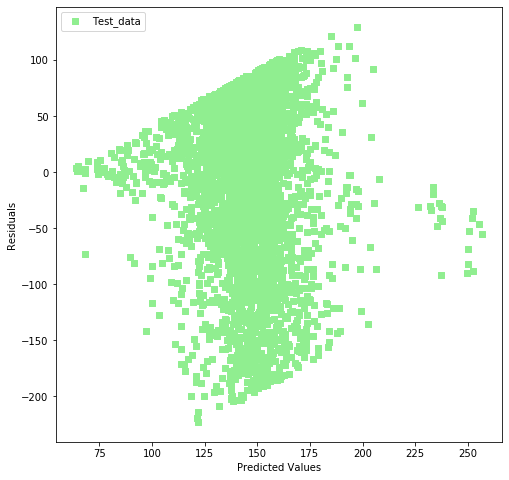

In [61]:
output='ClaimAmount'
pred = gs_dt.predict(X_test)
pred_df = pd.DataFrame(list(zip(X_test.index,pred)),columns=['id','pred_out'])
eval_df = pred_df.merge(DF[features+[output]],right_index=True,left_on='id').set_index('id')
eval_df['residuals'] = eval_df.pred_out-eval_df.ClaimAmount
RegModelEval(eval_df,n=len(y_test),show=True,output=output)

Looking at the residuals plot, one can observe that the residuals are not symmetric about 0. In fact there doesn't seem to be any pattern where most predictions are 0. The RSME doesn't seem too bad on a individual claim level, but the fit is bad

Standard Deviation of Residuals: 74.04964888314582


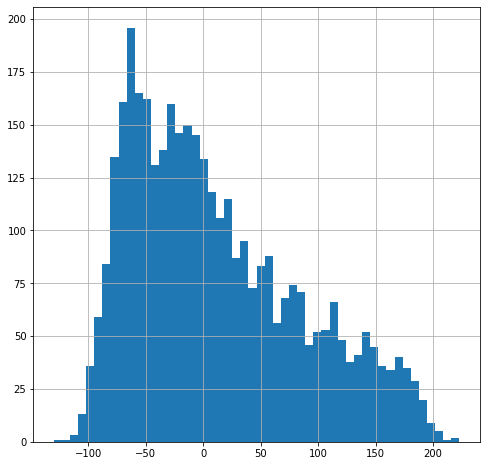

In [62]:
residuals = y_test-pred
residuals.hist(bins=50)
print('Standard Deviation of Residuals: {}'.format(residuals.std()))

Residuals are not distributed normally are skewed towards the left. 

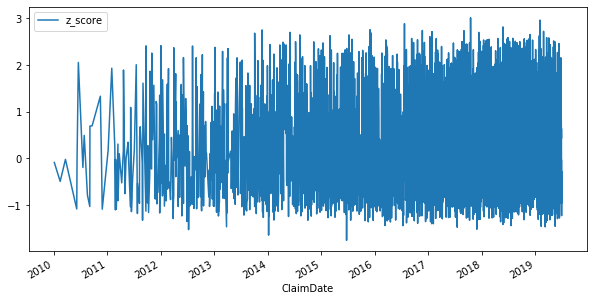

In [63]:
#plotting z scores to show lack of symmetry about 0
df_z =(residuals/residuals.std()).to_frame()
df_z.rename(columns={'ClaimAmount': 'z_score'},inplace=True)
df_z = DF[['ClaimDate']].merge(df_z,left_index=True,right_index=True)
df_z.plot(x='ClaimDate',y='z_score',figsize=(10,5))

Z scores are not symmetric about 0, suggesting regression is probably not the best model. 

In [64]:
#The z scores > 2 tend to show outliers. 
#outliers_df = eval_df.merge(df_z.loc[df_z.z_score>2],left_index=True,right_index=True)

R^2 Test: 0.16449
RMSE Test: 42.12635


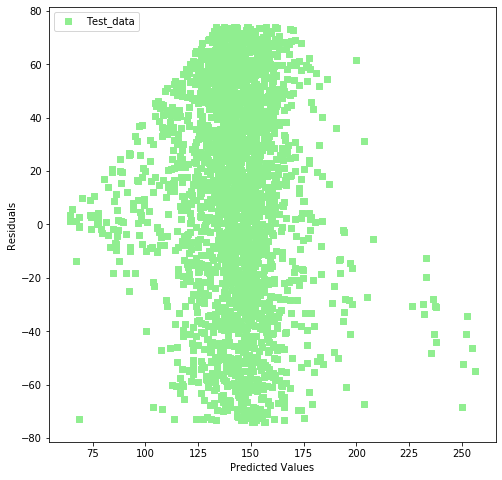

In [65]:
test_df = eval_df.merge(df_z.loc[(df_z.z_score > -1)& (df_z.z_score < 1)],left_index=True,right_index=True)
RegModelEval(test_df,n=test_df.shape[0],show=True,output=output)

Calculate the Prediction Interval

In [66]:
#Using 50% confidence interval where Zcr * stddev because the model doesn't spell confidence
#Zcr = 50%: .674,60%:.841 70%: 1.04, 80%: 1.28, 95: 1.96
interval = .674* residuals.std()
eval_df['upper_pred'] = eval_df.pred_out + interval
eval_df['lower_pred'] = eval_df.pred_out - interval
print('Prediction Interval: {:.3f}'.format(interval))

Prediction Interval: 49.909


In [67]:
eval_df[['ClaimAmount','pred_out','upper_pred','lower_pred','residuals']].head(10)

,ClaimAmount,pred_out,upper_pred,lower_pred,residuals
id,,,,,
21833,71.16,146.070511,195.979974,96.161048,74.910511
31444,103.14,150.072556,199.982019,100.163092,46.932556
18435,99.19,140.238480,190.147943,90.329016,41.048480
5212,192.40,147.327988,197.237451,97.418524,-45.072012
6795,267.17,172.197617,222.107080,122.288153,-94.972383
33128,95.22,128.553589,178.463052,78.644126,33.333589
13444,251.76,139.182449,189.091913,89.272986,-112.577551
31100,117.18,135.571671,185.481134,85.662207,18.391671
30888,179.40,148.392517,198.301980,98.483054,-31.007483


## Strategy 1 final results

In [43]:
#Get all petid enrolled in July 2019
july = datetime.strptime('2019-07-31','%Y-%m-%d')
july_ids = pet_df.loc[(pet_df.EnrollDate <= july) & ~(pet_df.CancelDate <= july)].sort_values(['EnrollDate','CancelDate'])

claim_df = pd.read_csv('./claimdata.csv',parse_dates=['ClaimDate'])
#DF = claim_df.merge(pet_df,on='PetId') 
#july_ids = july_ids.merge(claim_df,how='left',on='PetId')

In [44]:
#Get relevant info for input values
july_ids['ClaimMonth'] = 'July'
july_ids['ClaimYear']  = 2019
july_ids['ClaimDate'] = datetime.strptime('2019-07-31','%Y-%m-%d')
july_ids['EnrollMonth'] = july_ids.apply(lambda row: row.EnrollDate.month_name(),axis=1)
july_ids['EnrollYear'] = july_ids.apply(lambda row: row.EnrollDate.year,axis=1)
july_ids['EstEnrollAge'] = july_ids.apply(lambda row: ages[row.AgeAtEnroll],axis=1)
july_ids['DaysFromEnroll'] = july_ids.apply(lambda row:(row.ClaimDate-row.EnrollDate).days , axis=1)
july_ids['YearsFromEnroll'] = round(july_ids.DaysFromEnroll/365.0).astype(int)
july_ids['MonthsFromEnroll'] = july_ids.apply(lambda row:int(round((row.ClaimDate-row.EnrollDate).days/365*12)) , axis=1)
july_ids['EstCurrentAge'] = july_ids.EstEnrollAge + july_ids.YearsFromEnroll

max_previousclaims = DF[['PetId','PreviousClaims']].groupby(['PetId'])[['PreviousClaims']].max()
max_claims2019 = DF.loc[(DF.ClaimDate<=july) & (DF.ClaimYear==2019)][['PetId','PreviousClaimsYear']].groupby(['PetId'])[['PreviousClaimsYear']].max()

#Get Avg visits per year for petId 
#Get Avg Claim Amt per visit per year
#get average claim amount for breed & species
averages = DF[['PetId','AvgYearlyVisits','AvgYearlyClaimAmt']].drop_duplicates()
breed_df = DF[['PetId','Breed','Species','AvgYearlyBreedSpeciesClaimAmt']].drop_duplicates()

In [45]:
df2 = july_ids.merge(max_previousclaims,how='left',on='PetId')
df2 = df2.merge(max_claims2019,how='left',on='PetId')
df2 = df2.merge(averages,how='left',on='PetId')
df2 = df2.merge(breed_df,how='left',on=['PetId','Breed','Species'])
#if a petid has never filed a claim than they have no visits, claimamts, or previous claims
df2.fillna(0,inplace=True) 

In [46]:
#determining categorical and numerical features
categorical = ['ClaimMonth',
               'ClaimYear',
               'EnrollMonth',
               'EnrollYear',
               'Species',
               'Breed'
              ]
numerical = ['PreviousClaims',
             'EstCurrentAge',
             'EstEnrollAge',
             'MonthsFromEnroll',
             'PreviousClaimsYear',
             'AvgYearlyVisits',
             'AvgYearlyClaimAmt',
             'AvgYearlyBreedSpeciesClaimAmt'
            ]
features = categorical + numerical
input_test = df2[features]

In [48]:
interval*4981

248599.03693260386

In [57]:
expected_claim_total = gs_dt.predict(input_test).sum()
enrolled_july = enroll_df.loc[(enroll_df.Month=='July') & (enroll_df.Year==2019)].Enrolled.values[0]
claim_per_pet = expected_claim_total/enrolled_july
upper = expected_claim_total+interval*enrolled_july
lower = expected_claim_total-interval*enrolled_july
upper_petid = upper/enrolled_july
lower_petid = lower/enrolled_july
print('Expected Claim Amount with 50% Confidence Level between ${:,.2f} - ${:,.2f}'.format(lower,upper))
print('The Expected Claim Amount for July 2019: ${:,.2f}'.format(expected_claim_total))
print('The Total Number of Currently Enrolled PetIds at Start of July: {}'.format(enrolled_july))
print('Expected Claim Amount per PetId with 50% Confidence Level between ${:,.2f} - ${:,.2f}'.format(lower_petid,upper_petid))
print('Expected Claim Amount per PetId: ${:,.2f}'.format(claim_per_pet))

#sanity check
jan_july2017_amt = DF.loc[(DF.ClaimMonthNum.isin(np.arange(1,8))) & (DF.ClaimYear==2017)].ClaimAmount.sum()
jan_july2018_amt = DF.loc[(DF.ClaimMonthNum.isin(np.arange(1,8))) & (DF.ClaimYear==2018)].ClaimAmount.sum()
jan_june2019_amt = DF.loc[(DF.ClaimMonthNum.isin(np.arange(1,7))) & (DF.ClaimYear==2019)].ClaimAmount.sum()

print('\nJanuary - July 2017 Total Claim Amount: ${:,.2f}'.format(jan_july2017_amt))
print('January - July 2018 Total Claim Amount: ${:,.2f}'.format(jan_july2018_amt))
print('January - July 2019 Total Claim Amount: ${:,.2f}'.format(jan_june2019_amt+expected_claim_total))

Expected Claim Amount with 50% Confidence Level between $254,120.65 - $751,318.72
The Expected Claim Amount for July 2019: $502,719.69
The Total Number of Currently Enrolled PetIds at Start of July: 4981
Expected Claim Amount per PetId with 50% Confidence Level between $51.02 - $150.84
Expected Claim Amount per PetId: $100.93

January - July 2017 Total Claim Amount: $301,025.39
January - July 2018 Total Claim Amount: $347,256.59
January - July 2019 Total Claim Amount: $832,110.95


Using a 50% confidence interval, I predict that for the time July 2019 Trupanion would expect to receive between \\$254,120.65 - \\$751,318.72. In July 2019 there are 4981 pets enrolled, and the claim per pet id would be between \\$51.02 - \\$150.84.

While the total amount expected of \\$502,719.69 is way overestimating the expected amount Trupanion is most likely to receive. The Expected Claim Amount per PetId sounds a bit more reasonable because normally you would expect all pets to make claims in one month. Out of the 4981 enrolled pets, only 1680 have filed previous claims. Due to the results, I would not personally recommend this particular model to run in production due to the errors. 

# Modeling Strategy 2

Modeling Strategy Recap

I want to reduce the data to a claim month,year level and try to predict the total amount of claims for July 2019. Because there is large amount of correlation and regression in total sum of claims as a function of time. Rather than trying to predict all the PetId amount individually I just sum up what we expect to get total for July 2019 and then using all the pets currently enrolled get a value per petId


In [11]:
#cross validation
#test/validation set being 25% of the 80% of training size being 20% of the original set of data. 
cv = ShuffleSplit(n_splits=100,test_size=.25,random_state=42)

## Linear Regression

I expect a linear regression to be quite powerful for this particular strategy due to the linear correlations in relationships

In [12]:
param_grid = [{'mdl__normalize': [True,False],
               'mdl__fit_intercept': [True,False]}
             ]

pipe = Pipeline([
        ('features',FeatureUnion([
            ('numeric_feats',ColumnSelector(cols=numerical)),
            ('categorical_feats',Pipeline([
                ('categories',ColumnSelector(cols=categorical)),
                ('encoder',OneHotEncoder(handle_unknown='ignore',sparse=False)),
            ]))
        ])),
        ('ft_scale',StandardScaler(with_mean=False)),
        ('mdl',LinearRegression())
])

In [21]:
gs_dt2 = GridSearchCV(pipe,
                    param_grid,
                    scoring='explained_variance',
                    return_train_score=True,
                    cv=cv,n_jobs=5,verbose=3,error_score='raise')
gs_dt2.fit(X_train,y_train)

Fitting 100 folds for each of 4 candidates, totalling 400 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 378 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 400 out of 400 | elapsed:    0.9s finished


GridSearchCV(cv=ShuffleSplit(n_splits=100, random_state=42, test_size=0.25, train_size=None),
             error_score='raise',
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('numeric_feats',
                                                                        <__main__.ColumnSelector object at 0x7f37a667ee90>),
                                                                       ('categorical_feats',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('categories',
                                                                                         <__main__.ColumnSe...
                                        StandardScaler(copy=True,
                            

In [22]:
"""
Linear Regression (1st): Train Score: 0.9708329439788298, Test Score: 0.9390539036117437
"""

estimator,model,params,test_score,train_score = best_params(gs_dt2)
print('Train Score: {}, Test Score: {}'.format(train_score,test_score))

Train Score: 0.9708329439788298, Test Score: 0.9390539036117437


The values seem to show a great predictive indictor in linear relationship. However, it does show signs of overfitting and this can be a result of smaller data size for training. It doesn't have as much data to generalize. 

## Model Evaluation for Strategy 2

R^2 Test: 0.91909
RMSE Test: 29837.23281


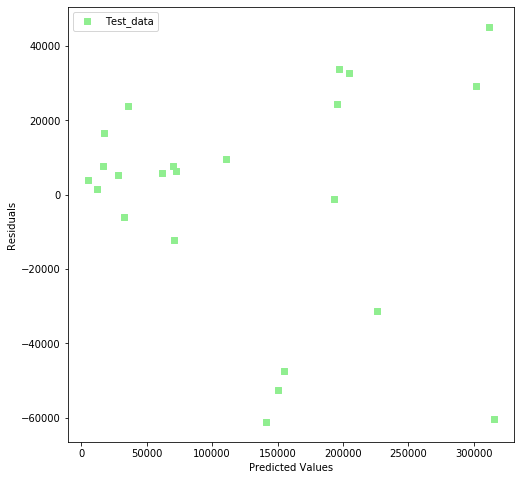

In [28]:
output='ClaimAmtTotal'
pred = gs_dt2.predict(X_test)
pred_df = pd.DataFrame(list(zip(X_test.index,pred)),columns=['id','pred_out'])
eval_df = pred_df.merge(DF[features+[output]],right_index=True,left_on='id').set_index('id')
eval_df['residuals'] = eval_df.pred_out-eval_df.ClaimAmtTotal
RegModelEval(eval_df,n=len(y_test),show=True,output=output)

Great $R^2$ value, it is greater than .9, but the mean squared error is very large. The error is quite large. The model fits well with out data but produces errors, which is to be expected with small training and test data sizes. 

Standard Deviation of Residuals: 30497.73924672768


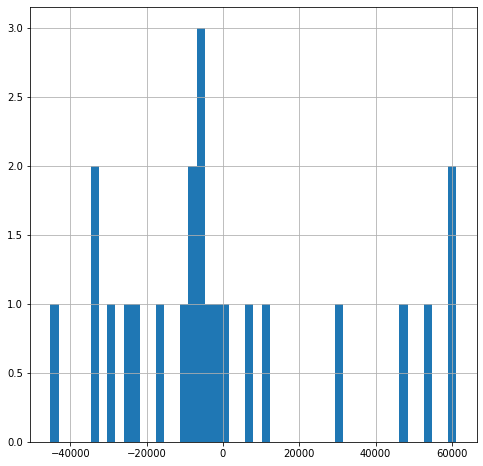

In [29]:
residuals = y_test-pred
residuals.hist(bins=50)
print('Standard Deviation of Residuals: {}'.format(residuals.std()))

The residuals don't seem to be normally distributed.

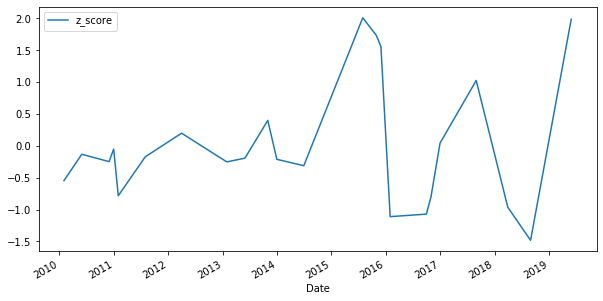

In [30]:
df_z =(residuals/residuals.std()).to_frame()
df_z.rename(columns={output: 'z_score'},inplace=True)
df_z = DF[['Date']].merge(df_z,left_index=True,right_index=True)
df_z.plot(x='Date',y='z_score',figsize=(10,5))

In [32]:
eval_df.head()

,pred_out,ClaimMonth,ClaimYear,Enrolled,ClaimAmtTotal,residuals
id,,,,,,
111,204940.822133,September,2016,4373,172248.01,32692.812133
77,5293.460265,May,2010,181,1219.05,4074.410265
80,61815.043477,May,2013,1795,55903.65,5911.393477
101,150351.761643,October,2015,3767,203014.12,-52662.358357
87,16529.810770,November,2010,442,8936.59,7593.220770


The Z-scores aren't symmetric about 0. The data doesn't seem so bad from 2010-2014 but 2015+ is when more claims happened and the expected claim amount start to grow. 

R^2 Test: 0.89476
RMSE Test: 10667.84038


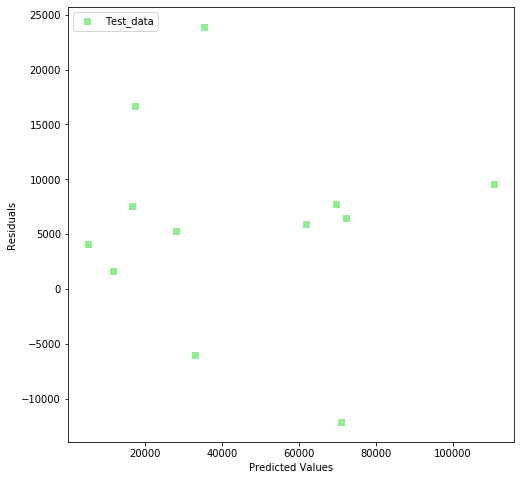

In [34]:
test_df = eval_df.loc[eval_df.ClaimYear<2015]
RegModelEval(test_df,n=test_df.shape[0],show=True,output=output)

You can see that if you only look at data pre-2015 the fit and RMSE do better. 

R^2 Test: 0.51878
RMSE Test: 41680.99284


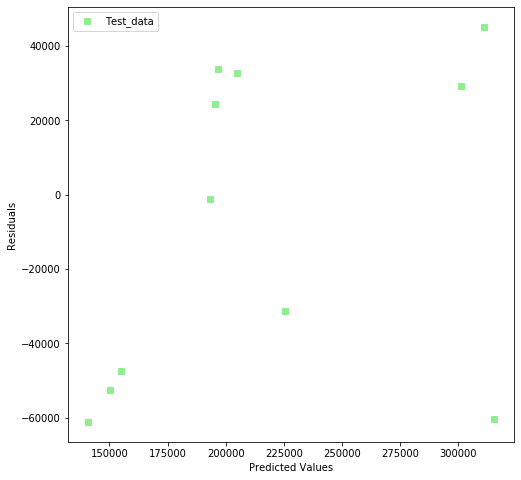

In [35]:
test_df = eval_df.loc[eval_df.ClaimYear>2014]#eval_df.merge(df_z.loc[(df_z.z_score > -1)& (df_z.z_score < 1)],left_index=True,right_index=True)
RegModelEval(test_df,n=test_df.shape[0],show=True,output=output)

However, 2015+ you begin to start to see larger errors and less fit to the data.

In [36]:
#Using 95% confidence interval where Zcr * stddev
#Zr values are 50%: .674, 60%:.841 70%: 1.04, 80%: 1.28, 95%: 1.96
interval = 1.96* residuals.std()
eval_df['upper_pred'] = eval_df.pred_out + interval
eval_df['lower_pred'] = eval_df.pred_out - interval
print('Prediction Interval: {:.3f}'.format(interval))

Prediction Interval: 59775.569


In [37]:
to_plot = eval_df.merge(DF[['ClaimMonth','ClaimYear','Date']],on=['ClaimYear','ClaimMonth'])
to_plot.rename(columns={'pred_out': 'Predicted','ClaimAmtTotal':'Actual'},inplace=True)

Text(0, 0.5, 'ClaimAmount')

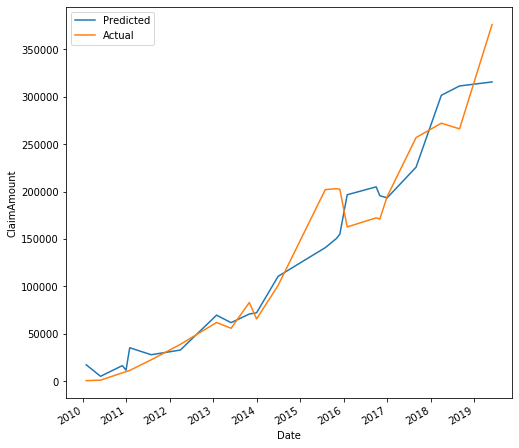

In [38]:
to_plot.plot(x='Date',y=['Predicted','Actual'])
plt.ylabel('ClaimAmount')

## Strategy 2 Final Results

In [47]:
DF.loc[(DF.ClaimMonth.isin(mths)) & (DF.ClaimYear==2017)]

,ClaimMonth,ClaimYear,TotalVisits,ClaimAmtTotal,Year,Month,Date,Enrolled
45,January,2017,510,226559.78,2017,January,2017-01-31,4457
35,February,2017,528,212184.26,2017,February,2017-02-27,4461
74,March,2017,573,214764.54,2017,March,2017-03-31,4445
7,April,2017,528,190884.84,2017,April,2017-04-30,4442
84,May,2017,541,174763.51,2017,May,2017-05-31,4446
64,June,2017,583,238039.42,2017,June,2017-06-30,4463
55,July,2017,549,198520.29,2017,July,2017-07-31,4487


In [55]:
#Predict What the total Claim Amount sum would be for July 2019
#Predict with 95% confidence/prediction interval for standard range
test = pd.DataFrame({'ClaimMonth': ['July'], 'ClaimYear': [2019], 'Enrolled': [4981]})
expected_claim_total = gs_dt2.predict(test)[0]
enrolled_july = enroll_df.loc[(enroll_df.Month=='July') & (enroll_df.Year==2019)].Enrolled.values[0]
claim_per_pet = expected_claim_total/enrolled_july
upper = expected_claim_total+interval
lower = expected_claim_total-interval
upper_petid = upper/enrolled_july
lower_petid = lower/enrolled_july
print('Expected Claim Amount with 95% Confidence Level between ${:,.2f} - ${:,.2f}'.format(lower,upper))
print('The Expected Claim Amount for July 2019: ${:,.2f}'.format(expected_claim_total))
print('The Total Number of Currently Enrolled PetIds at Start of July: {}'.format(enrolled_july))
print('Expected Claim Amount per PetId with 95% Confidence Level between ${:,.2f} - ${:,.2f}'.format(lower_petid,upper_petid))
print('Expected Claim Amount per PetId: ${:,.2f}'.format(claim_per_pet))

#sanity check
july2017_amt = DF.loc[(DF.ClaimMonth=='July') & (DF.ClaimYear==2017)].ClaimAmtTotal.values[0]
july2018_amt = DF.loc[(DF.ClaimMonth=='July') & (DF.ClaimYear==2018)].ClaimAmtTotal.values[0]

print('\nJanuary - July 2017 Total Claim Amount: ${:,.2f}'.format(july2017_amt))
print('January - July 2018 Total Claim Amount: ${:,.2f}'.format(july2018_amt))
print('January - July 2019 Expected Total Claim Amount: ${:,.2f}'.format(expected_claim_total))

Expected Claim Amount with 95% Confidence Level between $257,150.28 - $376,701.41
The Expected Claim Amount for July 2019: $316,925.84
The Total Number of Currently Enrolled PetIds at Start of July: 4981
Expected Claim Amount per PetId with 95% Confidence Level between $51.63 - $75.63
Expected Claim Amount per PetId: $63.63

January - July 2017 Total Claim Amount: $198,520.29
January - July 2018 Total Claim Amount: $333,238.84
January - July 2019 Expected Total Claim Amount: $316,925.84


Using a 95% confidence interval, I predict that for the time July 2019 would expect to receive between \\$257,150.28 - \\$376,701.41. In July 2019 there are 4981 pets enrolled, and the claim per pet id would be between \\$51.63 - \\$75.63.

The results show a large mean square error, which can be attributed to less data to train on for this level. This error is noticeable as the expected value isn't higher than 2018's value which we would expect it to be. 

# Conclusion

Comparing Strategy 1 to Strategy 2 provides some interesting insights. Although Strategy 2 has an amazing $R^2$ value close to .95-.97 and predicts an expected claim amount of \\$316,925.84 which is in line with what we would expect to receive compared with 2017, 2018 data. It does underestimate a bit. Also, it seems to underestimate the expected claims per petid considering the mean claim amount for pets seems to be around $150. 

This is in contrast to Strategy 1 that poorly predicts expected claim amount total for July 2019. To be within acceptable levels, we would have to use lower limits of prediction intervals to get values that align with 2017, 2018 claim data. However, it does produce a higher value for claim amount per pet id that would be much closer than strategy 2's value. 

If I had to choose a model to predict the expected claim amount total for July 2019 I would choose strategy/approach 2. As the result, confirms some of the exploratory analysis. 

### Final Results
Expected Claim Amount with 95% Confidence Level between __\\$257,150.28 - \\$376,701.41__  
The Expected Claim Amount for July 2019: __\\$316,925.84__  
The Total Number of Currently Enrolled PetIds at Start of July: __4981__  
Expected Claim Amount per PetId with 95\% Confidence Level between __\\$51.63 - \\$75.63__  
Expected Claim Amount per PetId: __\\$63.63__
